# Topic modeling with NMF and SVD
Topic Modeling is an unsupervised learning approach to figure out what is the best title for your document. Or Add title for ad copy, etc. 

The idea of matrix decompensition is taking one matrix and representing it as a few matrices. So example: Multiplying (matrix product) of these newly formed matrix will represent the original matrix. 

Example: We can decompose one large matrix into one tall thin matrix times one wide short matrix (possibly with a diagonal matrix in between). 

An example of this is called *latent semantic analysis (LSA)*. 

## Motivation 
Consider the most extreme case - reconstructing the matrix using an outer product of two vectors. Clearly, in most cases we won't be able to reconstruct the matrix exactly. But if we had one vector with the relative frequency of each vocabulary word out of the total word count, and one with the average number of words per document, then that outer product would be as close as we can get. 

Now consider increasing that matrices to two columns and two rows. The optimal decomposition would now be to cluster documents into two groups, each of which has as different distribution of words as possible to each other, but as similar as possible amongst the documents in the cluster. 

We will call those two groups "Topics". And we would cluster the words into two groups, based on those which most frequently appear in each of the topics. 

## Getting started
We'll take a dataset of documents in several different categories, and find topics (consisting of groups of words) for them. Knowing the actual categoies helps us evaluate if the topic we find make sense. 

We will try this with two matrix factorizations: **Singular Value Decomposition (SVD)** and **Non-Negative Matrix Factorization**. 

### Singular Value Decomposition
$$ A_{[m x n]} = U_{[m x n]} \sum_{[r x r]}(V_{[n x r]})^T$$

In which case $A$ in the **input data matrix** of size (m x n) where $m$ can be documents and $n$ can be terms. Therefor $m$ represents the rows and $n$ represents the columns in the matrix. 

So with **SVD** we take this initial input data matrix and we represent it as a *product* of three matrices. 

Therefor $U$ is the **left singular vectors** of shape (m x r) that is this matrix stores *left singular vectors* which can be represented as $m$ documents and $r$ concepts. 

our matrix $\sum$ is called the **Singular values** matrix where: 
* r x r diagonal matrix (strenght of each 'concept')
    * Contains zeros everywhere except diagonal which are singular values. These singular values are sorted in decreasing order. 
* r: rank of Matrix **A**

Lastly we have $V$ which is called the **Right singular vectors**. The size of this matrix is (n x r) where $n$ represents terms and $r$ represents concepts. We also **transpose** this vector.

#### SVD Properties
It is always possible to decompose a real Matrix $A$ into $A = U \sum V^T$ where:
* $U, \sum, V$: are unique
* $U, V$: column orthonormal
* $\sum$: Diagonal
    * Entries (Singular values) are positive and sorted in decreasing order
    
What is essentially happening with **SVD** is that we are able to **cluster** what a matrix represents via "Concepts" which are the right and left singular vectors with the singular values acting as weights or strength towards the concepts learned. 

These concepts aren't given to the model - they are simply learned via preference. 

### Non-Negative Matrix Factorization (NMF)
For a matrix $V$ of dimensions (m x n) where each element $v_{ij} \ge 0$, NMF decomposes it into two matrices $W$ and $H$ of dimensions (m x r) and (r x n) respectively, where each element $w_{ij} \ge 0$ and $h_{ij} \ge 0$ and $r < min(m,n)$

such that: 

$$W * H = V$$

The problem cannot be solved analytically so it is generally approximated numerically. 

$W, H$ are lower dimensional representations (latent space) of matrix $V$

* So $V$ is decomposed into a tall, skinny matrix $W$ and a short, wide matrix $H$
* The user can specify $r$, the inner dimension of $W$ and $H$, as long as it is $r < min(m,n)$
* We see that each column of $V$, $v_i$, can be calcualted as:
$$v_i = W * h_i$$
* That is, each column of $V$ is equal to the sum of each column of $W$ after being weighted by its corresponding row $h_j$

NMF is a way of reducing the dimensionality of our data into a **linear combination of bases**. 

In [5]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [6]:
%matplotlib inline
np.set_printoptions(suppress=True)

In [7]:
# We will pick a few topics from our entire dataset
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes') # for each document

# Creating train and test datasets
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [8]:
# printing the shape of our datasets
newsgroups_train.filenames.shape, newsgroups_test.filenames.shape

((2034,), (1353,))

In [9]:
# Showing one message
print('\n'.join(newsgroups_train.data[:3]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.c

In [10]:
# What are the targets for the top three?
np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space'], dtype='<U18')

In [11]:
# The target attribute is the integer index of the category
newsgroups_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1])

In most 'cluster analysis' task we have to choose how many 'topics' or 'concepts' we want to create. We will represent this as ```num_topics, num_top_words```

In [12]:
# This can be treated as a parameter to experiment with
num_topics, num_top_words = 6, 8

### Stop Words
Some extreme common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called **stop words**. 

Generally stop words aren't used any more but we will do so in this case because we are using a small dataset and a simple model. 

In [13]:
# importing stop words
from sklearn.feature_extraction import stop_words

sorted(list(stop_words.ENGLISH_STOP_WORDS))[:20]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst']

### Stemming and Lemmatization
Are the words below the same? 

*organize, organizes, organizing* 

*democracy, democratic, democratization*

Stemming and Lemmatization both generate the root form of the words. 

Lemmatization uses the rules about a language. The resulting tokens are all actual words.

Stemming is the poor-mans's lemmatization. Stemming is a crude heuristic that chops the end off of the word. The resulting token may not be actual words. Stemming is faster.

In [14]:
import nltk
from nltk import stem

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/diegomedina-
[nltk_data]     bernal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
# Lemmatizer, Stemmer
wnl = stem.WordNetLemmatizer()
porter = stem.porter.PorterStemmer()

In [16]:
# Testing word list
word_list = ['feet', 'foot', 'foots', 'footing']

In [17]:
print([wnl.lemmatize(word) for word in word_list]) # lemmatization
print([porter.stem(word) for word in word_list]) # stemming

['foot', 'foot', 'foot', 'footing']
['feet', 'foot', 'foot', 'foot']


In [18]:
# Trying more words
def stem_lemm(word_list):
    print('-----------------------------------------------------------------')
    print(f'Original List of word: {word_list}')
    print(f'Lemmativation of word list: {[wnl.lemmatize(word) for word in word_list]}')
    print(f'Stemming of word list: {[porter.stem(word) for word in word_list]}')
    print('-----------------------------------------------------------------')
    
# Word lists 
list_one = ['fly', 'flies', 'flying']
list_two = ['organize', 'organizes', 'organizing']
list_three = ['universe', 'university']

# calling stem_lemm
stem_lemm(list_one)
stem_lemm(list_two)
stem_lemm(list_three)

-----------------------------------------------------------------
Original List of word: ['fly', 'flies', 'flying']
Lemmativation of word list: ['fly', 'fly', 'flying']
Stemming of word list: ['fli', 'fli', 'fli']
-----------------------------------------------------------------
-----------------------------------------------------------------
Original List of word: ['organize', 'organizes', 'organizing']
Lemmativation of word list: ['organize', 'organizes', 'organizing']
Stemming of word list: ['organ', 'organ', 'organ']
-----------------------------------------------------------------
-----------------------------------------------------------------
Original List of word: ['universe', 'university']
Lemmativation of word list: ['universe', 'university']
Stemming of word list: ['univers', 'univers']
-----------------------------------------------------------------


### When to use?
When to use Stop Words? Lemmanization? Stemming? 

Using these methods are a way of throwing away information and truly depeneds on the model you use. If you model allows for more complexity - such as utilizing a deep learning model - then it would be best not to use these. 

As they can hurt your performance if using deep learning.

Therefore the convention is to use them for smaller models - which is often the case when you are dealing with much smaller datasets (unless you use transfer learning). 

## Data Processing
Next, SciKit Learn has a method that will extract all the word counts for us.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [20]:
# instantiating
vectorizer = CountVectorizer(stop_words='english') # removes stop words by default

In [21]:
# creating vector from our train data
vectors = vectorizer.fit_transform(newsgroups_train.data).todense()

# checking the shape
vectors.shape

(2034, 26576)

above our shape of the vector is (2034, 26576). We can view this as: 2034 different postings (rows), 26576 tokens/words (columns)

In [22]:
# to support this: let's check the size of our vocab from the vector
vocab = np.array(vectorizer.get_feature_names())

vocab.shape

(26576,)

In [23]:
vocab[7000:7020]

array(['cosmonauts', 'cosmos', 'cosponsored', 'cost', 'costa', 'costar',
       'costing', 'costly', 'costruction', 'costs', 'cosy', 'cote',
       'couched', 'couldn', 'council', 'councils', 'counsel',
       'counselees', 'counselor', 'count'], dtype='<U80')

### More on SVD
We would clearly expect that words that appear most frequently in one topic appear less frequently in the other - otherwise that word wouldn't make a good choice to seperate out the two topics. Therefore, we expect the topics to be **orthogonal**. 

The SVD algorithm factorizes a matrix into one matrix with **orthogonal columns** and one with **orthogonal rows** (along with a diagonal matrix, which contains the **relative importance** of each factor). 

#### Orthogonal Matrix
An orthogonal matrix is a *square matrix* whose columns and rows are *orthogonal unit vectors* 
$$Q^TQ = QQ^T = I$$

Where $I$ iss the identity matrix. 

This leads to the equibalent characterization: a matrix Q is orthogonal if its *transpose* is equal to its *inverse*

$$Q^T = Q^{-1}$$

SVD is an **exact decomposition**, since the matrices it creates are big enough to fully cover the original matrix. SVD is extremely widely used in linear algebra, and specifically in data science including: 
* Semantic analysis
* Collaborative Filterting/Recommendation
* Calculate Moore-Penrose pseudoinverse
* Data compression
* Principal componenet analysis

Latent Semantic Analysis (LSA) uses SVD. You will sometimes hear topic modelling reffered to as LSA.

In [24]:
# vectors: Input Matrix
# U: matrix
# s: singular values 
# Vh: matrix
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 1min 20s, sys: 3.24 s, total: 1min 23s
Wall time: 22.1 s


In [25]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


In [26]:
s[:4]

array([433.92698542, 291.51012741, 240.71137677, 220.00048043])

In [27]:
# s is shown as a vector but we can use np.diag() to create our diagonal matrix
np.diag(s[:4])

array([[433.92698542,   0.        ,   0.        ,   0.        ],
       [  0.        , 291.51012741,   0.        ,   0.        ],
       [  0.        ,   0.        , 240.71137677,   0.        ],
       [  0.        ,   0.        ,   0.        , 220.00048043]])

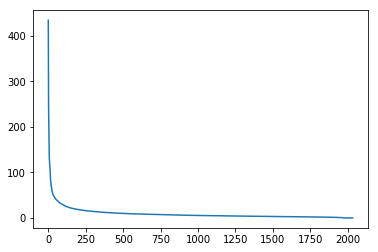

In [28]:
# Plotting our singular values
plt.plot(s)

In [29]:
# Let's show topics from SVD - Concepts we learned
num_top_words  = 8 # How many words to show

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t)for t in a])
    return [' '.join(t) for t in topic_words]

In [30]:
show_topics(Vh[:10])

['critus ditto propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display',
 'god atheists atheism religious believe religion argument true',
 'space nasa lunar mars probe moon missions probes',
 'image probe surface lunar mars probes moon orbit',
 'argument fallacy conclusion example true ad argumentum premises',
 'space larson image theory universe physical nasa material']

If there is still confusion from seeing the above. What we have essentially done is the following: We gathered 2000 documents from (4) pre-determined topics. From each document we gathered all of the vocab and then created a large matrix (vectors) of size (m, n) where m represents the document and n represents the word with each element within the matrix representing how many times (frequency) that single word appeared in the document. 

Then with doing SVD - we model our 'concepts' and it does this simply by knowing the different documents and all the words within the docouments (freq). 

So show_topics returns a list of vocabularly (num of words) with each element representing a different cluster or 'concept' 

Therefor if you read the second element: 'jpeg gif file color quality image jfif format' - we know from our knowledge of the original database that this unsupervised learning task has learned these words fall into a similar topic. 

The model doesn't know this topic is 'graphics' but we do. 

## Non-Negative Matrix Factorization (NMF)
Rather than constraining our factors to be *orthogonal*, another idea would be to constrain them to be non-negative. NMF is a factorization of a non-negative data set: $V$: 

$$V = W H$$

Into non-negative matrices $W, H$. Often positive factors will be **more easily iterpretable**. (how do you explain a negative value? - problem with SVD).

So if $V$ was vectorized images. Then this can be represented as $W$ being facial features times $H$ as the importance of features in each image. 

In [39]:
vectors.shape

(2034, 26576)

In [40]:
m, n = vectors.shape
d = 5 # number of topics / concepts we want to learn 

In [42]:
clf = decomposition.NMF(n_components=d, random_state=1)

W1 = clf.fit_transform(vectors) # Matrix one 
H1 = clf.components_            # Matrix two

In [43]:
# Showing our topics learned - 5
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

If you're having confusion as to what is happening above. Remember ```vectors``` is simply a matrix of size (m,n) where ```m``` represents document and ```n``` represents the word in that document. 

Therefor each element is the frequency of that word in that specific document. 

```d``` is the number of topics/concepts we want to learn. 

```W1``` is the first decomposed matrix of size (m, r) where ```m``` is the document and ```r``` is the concept. In our case ```r``` = ```d``` so this matrix is learning 5 concepts or "topics". 

```H1``` is the second decomposed matrix of size (r, n) where ```r``` is the "topic" or concept to learn, while ```n``` is the word. 

So below lets check the dimensions to further weigh our intuition. 

In [45]:
print(f'W1: {W1.shape}')
print(f'H1: {H1.shape}')

W1: (2034, 5)
H1: (5, 26576)


So with ```show_topics(a)``` we are essentially displaying words that fall into the "topic" or concept learned. 

## Truncated SVD
We saved a lot of time when we calculated NMF by only calculating the subset of columns we were interested in. Is there a way to get this benefit with SVD? 

This is what Truncated SVD does: We are just interested in the vectors corresponding to the **largest** singular values. 

### Shortcomings of classical algorithms for decompisition
* Matrices are "Stupendously big" 
* Data are often **missing or inaccurate**. Why spend extra computational resources when imprecision of input limits precision of the output?
* **data transfer** now plays a major role in time of algorithms. Techniques that require fewer passes over the data may be substantially faster, even if they require more flops (Flops = floating point operations)

### Advantages of randomized algorithms
* Inherently stable
* Performance guarantees do not depend on subtle spectral properties
* Needed matrix-vector products can be done in parallel